# Allometry

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import pandas as pd
import glob
import os
import math
import importlib
from sklearn.metrics import r2_score
%matplotlib inline
import seaborn as sns

import amaizeing_utils as maize

## Load model data files

In [2]:
src = '../model/'
model_files = sorted(glob.glob(src+'*.csv'))
model_files

['../model/LPlant.L1_poly_model.csv',
 '../model/LPlant.L2_poly_model.csv',
 '../model/RPlant.L1_poly_model.csv',
 '../model/RPlant.L2_poly_model.csv']

In [5]:
def read_model_csv(model_file):
    csv_file = os.path.normpath(model_file).split(os.path.sep)[-1]
    bname = ''.join(csv_file.split('_')[0].split('.'))

    data = pd.read_csv(model_file)
    data = data.set_index('Unnamed: 0')
    data.index.rename('idx', inplace=True)

    print(bname, data.shape, sep='\t')
    return data

In [54]:
dataL = read_model_csv(model_files[1])
dataR = read_model_csv(model_files[3])

LPlantL2	(366, 23)
RPlantL2	(353, 23)


In [55]:
c = dataL.columns
rename_dict = {c[8]:'Tip.Angle',
               c[9]:'Tip.Distance',
               c[10]:'Apex.Angle',
               c[11]:'Apex.Distance',
               c[12]:'Stem.Angle',
               c[17]:'apex.x',
               c[18]:'tip.x',
               c[19]:'apex.y',
               c[20]:'tip.y'}
dataL.rename(columns=rename_dict, inplace=True)

In [56]:
c = dataR.columns
rename_dict = {c[8]:'Tip.Angle',
               c[9]:'Tip.Distance',
               c[10]:'Apex.Angle',
               c[11]:'Apex.Distance',
               c[12]:'Stem.Angle',
               c[17]:'apex.x',
               c[18]:'tip.x',
               c[19]:'apex.y',
               c[20]:'tip.y'}
dataR.rename(columns=rename_dict, inplace=True)

In [57]:
idx = dataL.index.intersection(dataR.index)
data = dataL.loc[idx].append(dataR.loc[idx], ignore_index=True, sort=False)

In [58]:
#data = dataL.merge(dataR, how='inner', on=list(data.columns[:8]))
print(data.shape)
data.head()

(566, 23)


,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,Tip.Angle,Tip.Distance,...,A1,N1,A2,N2,apex.x,tip.x,apex.y,tip.y,length,curled
0,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,83,40.0,...,0.000757,3.007398,-1.926790,1.818836,35.247650,39.701846,34.038260,4.874774,83.318879,0.0
1,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,47,39.0,...,0.549855,1.435147,-2.176995,1.337701,22.821386,28.522794,48.940620,26.597936,77.712970,0.0
2,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,78,39.0,...,0.027698,2.050304,-1.077360,1.480416,30.405592,38.147756,30.405592,8.108556,68.906309,0.0
3,MIH119_1007,9,2,1,B37/H95,B73/MO17,NaN,NaN,59,44.0,...,0.002691,2.808379,-2.311190,1.339725,32.120280,37.715361,45.872514,22.661675,84.791674,0.0
4,MIH119_1010,12,2,1,B37/H95,B37/H95,NaN,1.0,68,47.0,...,0.000034,3.971074,-0.520053,2.082613,36.135315,43.577641,51.606579,17.606510,106.686846,0.0


Enumerate all the available columns

In [59]:
for i,c in enumerate(data.columns):
    print(i,'\t',c)

0 	 plot
1 	 Pass
2 	 Range
3 	 Rep
4 	 New_Pedigree
5 	 Old_Pedigree
6 	 Old_Source
7 	 Shared
8 	 Tip.Angle
9 	 Tip.Distance
10 	 Apex.Angle
11 	 Apex.Distance
12 	 Stem.Angle
13 	 A1
14 	 N1
15 	 A2
16 	 N2
17 	 apex.x
18 	 tip.x
19 	 apex.y
20 	 tip.y
21 	 length
22 	 curled


Do an allometry plot and compute the $R^2$ score of the linear fit for every possible combination of parameters

In [60]:
importlib.reload(maize)
trait_s = 8
trait_f = 22
dpi = 100
write_file = False
plot_fig = False
cutoff = 160
X, Y, R2 = [], [], []
for i in range(trait_s,trait_f):
    for j in range(i+1, trait_f):
        x,y,r2 = maize.fit_allometry(data, i,j, dpi=dpi, plot_fig=plot_fig,w=write_file)
        R2.append(r2)
        X.append(x)
        Y.append(y)
R2 = np.array(R2)

In [61]:
allometry = pd.DataFrame((X,Y,R2), index=['X','Y','R2']).T
allometry.sort_values(by=['R2'], ascending=False).head()

,X,Y,R2
55,A1,N1,0.92796
70,A2,N2,0.794736
21,Tip.Distance,tip.x,0.741326
11,Tip.Angle,tip.y,0.597669
43,Apex.Distance,apex.y,0.591234


Text(0, 0.5, 'R2')

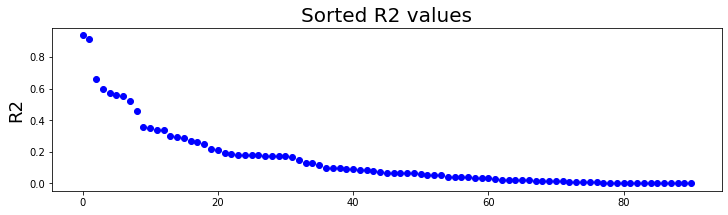

In [50]:
plt.figure(figsize=(12,3))
plt.plot(np.sort(R2)[::-1], 'ob')
plt.title('Sorted R2 values', fontsize=20)
plt.ylabel('R2', fontsize=18)

In [62]:
n = int((1+np.sqrt(1+8*len(R2)))*0.5)
allo_matrix = np.full((n,n), np.nan)
counter = 0
for i in range(n):
    for j in range(i+1,n):
        allo_matrix[i,j] = R2[counter]
        counter += 1

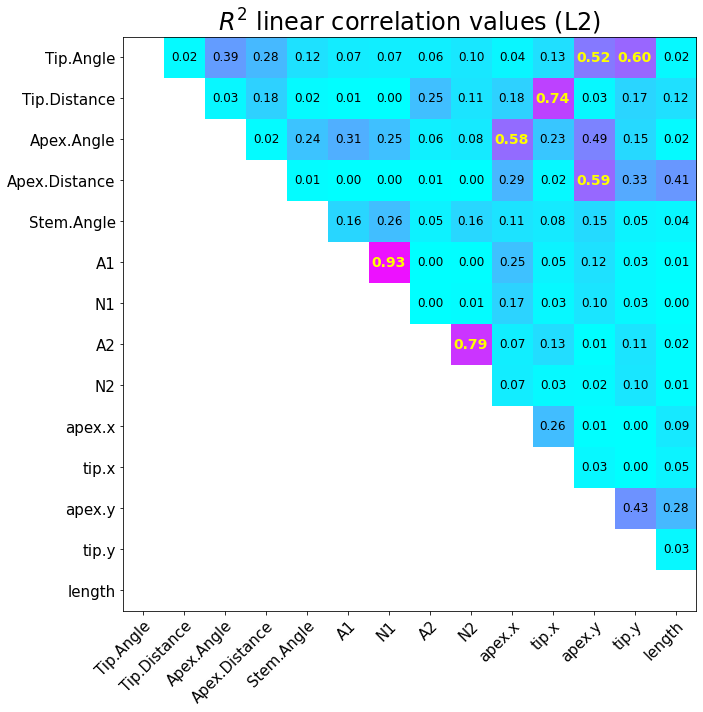

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(allo_matrix, cmap='cool', vmin=0, vmax=1)

# We want to show all ticks...
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
# ... and label them with the respective list entries
ax.set_xticklabels(data.columns[trait_s:trait_f])
ax.set_yticklabels(data.columns[trait_s:trait_f])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.tick_params(labelsize=15)

# Loop over data dimensions and create text annotations.
for i in range(n):
    for j in range(i+1, n):
        if allo_matrix[i,j] >= 0.49:
            tcolor = 'yellow'
            fw = 'bold'
            fs = 14
        else:
            tcolor = 'black'
            fw = 'normal'
            fs = 12
        text = ax.text(j, i, '{:.2f}'.format(allo_matrix[i, j]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)

ax.set_title("$R^2$ linear correlation values (L2)", fontsize=24)
fig.tight_layout()

dst = '../model/L2_'
filename = dst + 'allometry_matrix.jpg'
plt.savefig(filename, dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})